# Neural Net Language models

> Basic neuralnet-based language modeling 

In [ ]:
#| default_exp models.lm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

import lightning as L
from lightning import Trainer

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Tuple, Optional, Set
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab
from nimrod.utils import set_seed, get_device

import logging
logger = logging.getLogger(__name__)

# N_EPOCHS for training debuggging
ITER_MAX = 1

In [ ]:
set_seed(42)

Seed set to 42


In [ ]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

names:  ['emma', 'olivia', 'ava']


## Data formatting
given last n tokens we predict token n+1

In [ ]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [ ]:
# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]

In [ ]:
print(data[:3])

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]


In [ ]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


for each row in the dataset we expand all the combinations of ngrams

In [ ]:
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<pad>', '<unk>', '<bos>', '<eos>'])
print("vocabulary: ", v.vocabulary)


vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<bos>', '<eos>', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
CONTEXT_LEN = 3
X, y = make_dataset(data[:2], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<pad>', '<bos>'] F
['<pad>', '<bos>', 'F'] i
['<bos>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] <eos>
row:  ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<pad>', '<bos>'] B
['<pad>', '<bos>', 'B'] e
['<bos>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' '

In [ ]:
print(data[:2])

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']]


In [ ]:
# take first 80 sentences & look at context_length sequences
X, y = make_dataset(data[:80], v, verbose=True, context_length=CONTEXT_LEN)
print(len(X), len(y))

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<pad>', '<bos>'] F
['<pad>', '<bos>', 'F'] i
['<bos>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] <eos>
row:  ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<pad>', '<bos>'] B
['<pad>', '<bos>', 'B'] e
['<bos>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' '

## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [ ]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int = 30, # vocabulary size 
                n_emb:int = 10, # embedding dimension
                n_context:int = 3, # context size bigram/trigram, etc.
                n_h:int = 100 # hidden layer size
                ):
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        res = []
        for _ in range(n_iterations):
            out = [] # current sequence prediction
            context = [pad] * (self.n_context-1) + [bos]
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                if ix == eos:
                    break
                else:
                    out.append(ix)
            res.append(out)
        return(res)

### Usage

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 69])


## Build dataset by hand

In [ ]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data[:80]))
print("len Xtr: ", len(Xtr))
print("CONTEXT_LEN: ", CONTEXT_LEN)

Xtr (B, T):  torch.Size([2703, 3]) Ytr (B):  torch.Size([2703]) data: 80
len Xtr:  2703
CONTEXT_LEN:  3


### Overfit on subset of 80 first rows

In [ ]:

%%time
device = get_device()
device = 'cpu'
# lm.to(device)

# overfit on one big batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

  2%|▏         | 22/1000 [00:00<00:08, 121.40it/s]

4.269774436950684


 28%|██▊       | 280/1000 [00:01<00:03, 212.48it/s]

2.5679497718811035


 54%|█████▎    | 537/1000 [00:02<00:02, 202.17it/s]

2.3386898040771484


 79%|███████▉  | 794/1000 [00:03<00:00, 214.88it/s]

2.192124843597412


100%|██████████| 1000/1000 [00:04<00:00, 202.77it/s]

CPU times: user 3.01 s, sys: 365 ms, total: 3.38 s
Wall time: 4.97 s


[<matplotlib.lines.Line2D>]

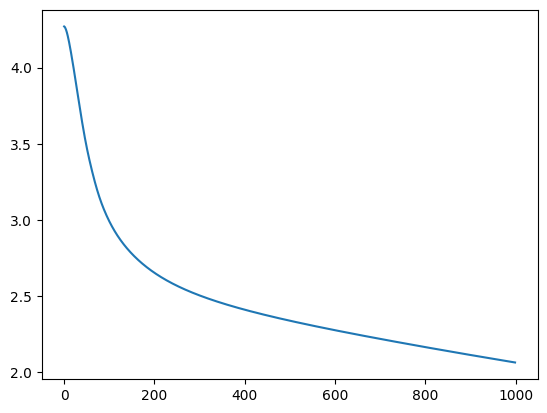

In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=10,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Helir?zripu miegs:
Wesibe enred Co do:
cors'l lits.
sct onmed: coy.
Ahl:
AYire, Co waml, men:st iuinizserey ceeroueeds hec,tonb;e?
; caleg, e snbdelplitstticun ou fo thv
A blf cou
 whr cs bam si3athoust Ciystowf rhe whanthlarve
Wuntr ioesdt you sa mo.


### Data module

In [ ]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
print(cfg)
cfg.train_val_test_split = [0.8, 0.1, 0.1]
# by default data_path is relative to the recipe folder so need to update for nbs
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2703 # large batch to mimic manual data order of magnitude
cfg.random_split = False
dm = instantiate(cfg)
dm.setup()
# setup large batch to overfit / test model
Xtr, Ytr= next(iter(dm.train_dataloader()))
# target is last token in sequence
Ytr = Ytr[:, -1]
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape)
X, Y = dm.data_train[0]
print(dm.ds.from_tokens(X), dm.ds.from_tokens(Y))


2024-12-17 22:32:12,704 - INFO - Initalizing CharDataModule
2024-12-17 22:32:12,704 - INFO - split data
2024-12-17 22:32:12,705 - INFO - CharDataset: ../data/text/tiny_shakespeare.txt, context_length: 3, specials: ['<pad>', '<unk>', '<bos>', '<eos>'], add_sentence_tokens: True


{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'train_val_test_split': [0.8, 0.1, 0.1], 'batch_size': 64, 'context_size': 3, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}
Xtr (B, T):  torch.Size([2703, 3]) Ytr (B):  torch.Size([2703])
<bos>Fi Fir


In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))


### overfit 

In [ ]:

%%time
# device = get_device()
device = 'cpu'
lm.to(device)

# overfit on one big batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 100
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

  0%|          | 35/10000 [00:00<00:54, 182.60it/s]

1.650428056716919


  3%|▎         | 283/10000 [00:01<00:35, 276.02it/s]

1.5600831508636475


  6%|▌         | 550/10000 [00:02<00:31, 296.46it/s]

1.474035382270813


  8%|▊         | 817/10000 [00:03<00:27, 339.09it/s]

1.3952633142471313


 10%|█         | 1042/10000 [00:04<00:37, 237.75it/s]

1.32319176197052


 13%|█▎        | 1295/10000 [00:05<00:23, 364.91it/s]

1.257137656211853


 15%|█▌        | 1547/10000 [00:05<00:24, 347.79it/s]

1.1965727806091309


 18%|█▊        | 1828/10000 [00:06<00:20, 395.78it/s]

1.1410638093948364


 21%|██        | 2057/10000 [00:07<00:21, 365.28it/s]

1.090108036994934


 23%|██▎       | 2298/10000 [00:07<00:19, 389.52it/s]

1.043241262435913


 25%|██▌       | 2546/10000 [00:08<00:18, 405.94it/s]

1.000185489654541


 28%|██▊       | 2792/10000 [00:09<00:17, 403.77it/s]

0.9607382416725159


 31%|███       | 3080/10000 [00:09<00:17, 405.82it/s]

0.9247205853462219


 33%|███▎      | 3316/10000 [00:10<00:18, 370.08it/s]

0.8919687867164612


 36%|███▌      | 3563/10000 [00:11<00:16, 400.02it/s]

0.8622792363166809


 38%|███▊      | 3812/10000 [00:11<00:15, 387.07it/s]

0.8353989124298096


 41%|████      | 4058/10000 [00:12<00:14, 399.44it/s]

0.8110570907592773


 43%|████▎     | 4303/10000 [00:12<00:14, 402.26it/s]

0.7889947295188904


 45%|████▌     | 4549/10000 [00:13<00:13, 403.40it/s]

0.7689796686172485


 48%|████▊     | 4820/10000 [00:14<00:13, 370.33it/s]

0.750812292098999


 51%|█████     | 5059/10000 [00:14<00:12, 395.61it/s]

0.73432457447052


 53%|█████▎    | 5291/10000 [00:15<00:13, 359.54it/s]

0.7193689942359924


 56%|█████▌    | 5574/10000 [00:16<00:11, 396.56it/s]

0.7058113813400269


 58%|█████▊    | 5820/10000 [00:16<00:10, 383.16it/s]

0.6935265064239502


 61%|██████    | 6063/10000 [00:17<00:09, 400.67it/s]

0.6823976039886475


 63%|██████▎   | 6307/10000 [00:18<00:09, 398.53it/s]

0.6723149418830872


 66%|██████▌   | 6570/10000 [00:18<00:10, 340.09it/s]

0.6631763577461243


 68%|██████▊   | 6801/10000 [00:19<00:08, 379.92it/s]

0.6548880338668823


 70%|███████   | 7043/10000 [00:20<00:07, 396.43it/s]

0.6473631262779236


 73%|███████▎  | 7287/10000 [00:20<00:07, 343.80it/s]

0.6405225992202759


 76%|███████▌  | 7560/10000 [00:21<00:06, 363.88it/s]

0.6342946290969849


 78%|███████▊  | 7792/10000 [00:22<00:05, 368.86it/s]

0.6286143660545349


 81%|████████  | 8076/10000 [00:22<00:04, 399.76it/s]

0.6234235763549805


 83%|████████▎ | 8321/10000 [00:23<00:04, 397.17it/s]

0.6186704635620117


 86%|████████▌ | 8550/10000 [00:24<00:04, 354.45it/s]

0.6143088936805725


 88%|████████▊ | 8800/10000 [00:25<00:03, 330.60it/s]

0.610298216342926


 91%|█████████ | 9077/10000 [00:25<00:02, 388.84it/s]

0.6066020131111145


 93%|█████████▎| 9307/10000 [00:26<00:01, 359.97it/s]

0.6031882762908936


 96%|█████████▌| 9573/10000 [00:27<00:01, 380.60it/s]

0.6000287532806396


 98%|█████████▊| 9793/10000 [00:27<00:00, 351.91it/s]

0.5970983505249023


100%|██████████| 10000/10000 [00:28<00:00, 353.31it/s]

CPU times: user 48 s, sys: 19.3 s, total: 1min 7s
Wall time: 28.3 s


[<matplotlib.lines.Line2D>]

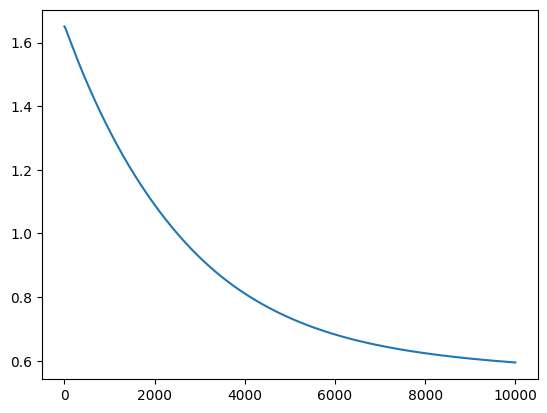

In [ ]:
plt.plot(train_loss)

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=10,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Woo dear me soymeneniseriry, busay wetously, were
while in to

oursl?

All:
Soft-cond corn at was do,
wholesolved utho country done help in not masters
IUS:
We are this natureb soft-cond toomlesolved, her for rest he soft! ourself with done ally ageb in han humanely;
business is in his rise this chief end: the have undone talpeak
Cirst: he abundo your malieven of ours, to you must matters,
enenius?

First Citizen:
Befor by, in he have hath for rest end to bends, minest Citizen:
Onest himself with famous
IIgSlt;y good
IUS:
Worthy Menenius breath for to till hat be die rats us: for his not in rell rema gainst enou
Wots; ther, he
common, is not fortnighbourseld you, we leannot he' one: away comes his is is cond Citizen:
Wortnight we his chief ends, ere
wholesome service
ISp stously
IKighbourse
have
they say uouity, is chief enough surply again him
Illt in revent thich superfluin hunge there?

Second Citizen:
Come, malim first Citizen:
First Citizen: work's, the particularise his andly:
We

In [ ]:
# mini batch gradient descent with datamodule
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.train_val_test_split = [0.8, 0.1, 0.1]
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 256
cfg.random_split = False
dm = instantiate(cfg)
dm.setup()

conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))


optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
# device = get_device()
device = 'cpu'
lm.to(device)
i = 0
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
    print(f"epoch {epoch}")
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        # target is last token in sequence
        Ytr = Ytr[:, -1] # BxT
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())
        i += 1

2024-12-17 22:45:34,605 - INFO - Initalizing CharDataModule
2024-12-17 22:45:34,606 - INFO - split data
2024-12-17 22:45:34,606 - INFO - CharDataset: ../data/text/tiny_shakespeare.txt, context_length: 3, specials: ['<pad>', '<unk>', '<bos>', '<eos>'], add_sentence_tokens: True
  0%|          | 0/1 [00:00<?, ?it/s]

epoch 0


4.284886360168457


2.351222276687622


2.7198843955993652


2.1130006313323975


100%|██████████| 1/1 [00:16<00:00, 16.51s/it]


[<matplotlib.lines.Line2D>]

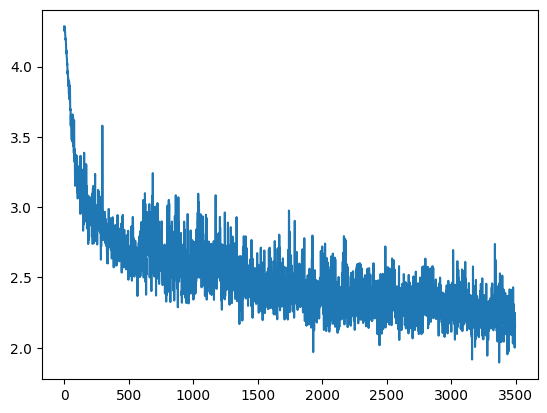

In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=10,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Aqnd end! oan
EAWTowh so mave pat I ceapso the th L
RSM
Cay carvelles migamaus and marellat py nowael
o& qttic- Gord ghat to ere hamene,
A yourd'd foth,
Thich in to dd cort of picfen
HIO:
L?O:
Boats bo'd inid tWeel
ARHCA
Ast rott
EO:
Hyeghich seese wo ce so fobm,:<unk>TAfd,:
Shit min so be to k that you sou
MRO:
As! wee woun teom und ay litse so hase pood way, all allecer
icee,
Aiven
The

iith rroure
Thith p? then trese sued bone favall pousunt, your kigese frfinse y wor,
Anfearss he momave pso you bxnd of pin sear in fouastill, I ond-
AR you the iterees, and an heaght geitim spspen, <pad>AATD yo winge bitht

ASer meem, wiect hilt may, your miky to it vet mant mins, an dearg;
<pad>QULAURDCICAAnnceN
beris ras, and meace, sor shy min
AUKon as ast' jo rore thisitce worino of me, I the pogke min hamith mpout, womriwe, Ihy mivse thain, atove
Teveires waoumee moon a diy then co
LNO:
WSELWAPd it arace iecerighe,
Ther f,
Wul meansiwhiltiy likest,
SA
Arare to de ird I dy
And'st:
TtI I LL:O:
IU<

## MLP LM L Model

In [ ]:
#| export 

class NNLM_L(L.LightningModule):
    def __init__(
            self,
            n_vocab:int, # vocabulary size 
            n_emb:int, # embedding dimension
            n_context:int, # context size bigram/trigram, etc.
            n_h:int, # hidden layer size
            lr:float=1e-3, # learning rate
            ):
        super().__init__()
        self.save_hyperparameters()
        self.model = NNLM(n_vocab, n_emb, n_context, n_h)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
    
    def configure_optimizers(self) -> Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1]) # as y is shifted by one (cf. karpathy tuto)
        self.log('train/loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('test/loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        return self.model.sample(n_iterations, eos, pad, bos)

### Usage

In [ ]:
# @dataclass
# class NNLMConfig:
#     n_vocab:int = 30
#     n_emb:int = 10
#     n_context:int = 3
#     n_h:int = 100
# dataclass
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM_L(**asdict(conf))
print(lm)

# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)
print(lm)

NNLM_L(
  (model): NNLM(
    (embedder): Embedding(69, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=69, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [ ]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [ ]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 70])


## L Training Loop

In [ ]:
# from nimrod.text.datasets import CharDataModule

cfg = OmegaConf.load('../config/text/data/tinyshakespeare.yaml')
cfg.data_path = '../data/text/tiny_shakespeare.txt'
dm = instantiate(cfg)
dm.setup()
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)

2024-12-17 22:59:14,094 - INFO - Initalizing CharDataModule
2024-12-17 22:59:14,101 - INFO - split data
2024-12-17 22:59:14,101 - INFO - CharDataset: ../data/text/tiny_shakespeare.txt, context_length: 3, specials: ['<pad>', '<unk>', '<bos>', '<eos>'], add_sentence_tokens: True


In [ ]:
# data formatting
dl = dm.test_dataloader()
x, y  = next(iter(dl))
print(x.shape, y.shape)
print(y[0], y[:, -1][0])


torch.Size([64, 3]) torch.Size([64, 3])
tensor([63, 20, 55]) tensor(55)


In [ ]:
trainer = Trainer(accelerator="auto", fast_dev_run=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


model can be easily trained with L trainer (c.f. recipes/text/ for examples)

``` python
trainer.fit(lm, dm)
```

## NN Bigram

In [ ]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self._vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
    @property
    def vocab_size(self)->int:
        return self._vocab_size


### Usage

In [ ]:

B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
print("vocab size: ",  model.vocab_size)
X = torch.randint(0,C,(B,T))
Y = torch.randint(0,C,(B,T))
batch = (X,Y)
logits = model(X) # (B, T, C)
print("X: ", X.shape, "Y: ", Y.shape, "logits: ", logits.shape)

vocab size:  65
X:  torch.Size([32, 8]) Y:  torch.Size([32, 8]) logits:  torch.Size([32, 8, 65])


In [ ]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0, 46, 50, 59, 59,  0, 47, 37,  3, 20, 11,  9, 60, 31, 39, 49, 34,  7,
        43,  9, 41, 24, 62,  8, 57,  3, 13, 59, 45, 33, 53,  5, 39, 23, 54, 33,
        29, 26, 41, 58, 34, 27, 52, 37, 44, 58,  5, 62,  0,  9, 10, 50,  6, 16,
        37, 24, 21, 13, 42, 32,  8, 57, 10,  5, 34, 27,  4,  7, 37, 27, 10, 60,
        56, 27, 24, 58, 39, 14, 54, 25,  7, 61, 53, 46, 16, 64, 34, 12, 54, 56,
        12, 46, 37, 46, 25, 58, 23, 12, 35, 47, 30])

In [ ]:

# #| export
# class NNBigramL(ModelModule):
#     def __init__(self, vocab_size:int, lr:float=1e-3):
#         model = NNBigram(vocab_size)
#         super().__init__(model, lr)
#         self.accuracy = Accuracy(task='multiclass', num_classes=model.vocab_size)

#     def _step(self, batch:torch.tensor, batch_idx:int):
#         x, y = batch
#         logits = self.model(x) # (B,T,C)
#         B, T, C = logits.shape
#         logits = logits.view(B*T, C)
#         y = y.view(B*T)
#         loss = self.loss(logits, y)
#         acc = self.accuracy(logits, y)
#         return loss, acc
    
#     def predict(self,idx:torch.IntTensor, max_new_tokens:int):
#         return self.model.predict(idx, max_new_tokens)

NameError: name 'ModelModule' is not defined

In [ ]:
# model_pl = NNBigramL(vocab_size)
# logits = model_pl(X) # (B, T, C)
# print(logits.shape)
# model_pl.training_step(batch, 0)
# model_pl._step(batch, 0)
     

### Data

In [ ]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [ ]:
# dataset
block_size = 8
ds = CharDataset(data_path='../data/text/tiny_shakespeare.txt', context_length=block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

2024-12-17 22:56:58,244 - INFO - CharDataset: ../data/text/tiny_shakespeare.txt, context_length: 8, specials: ['<pad>', '<unk>', '<bos>', '<eos>'], add_sentence_tokens: True


x: <bos>First C 
y: First Ci


In [ ]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [ ]:
model = NNBigram(ds.vocab_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [ ]:
%%time
ITER_MAX = 1000
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

 21%|██        | 211/1000 [00:00<00:00, 2106.53it/s]

4.992433071136475


100%|██████████| 1000/1000 [00:00<00:00, 2173.82it/s]

CPU times: user 505 ms, sys: 691 ms, total: 1.2 s
Wall time: 461 ms


[<matplotlib.lines.Line2D>]

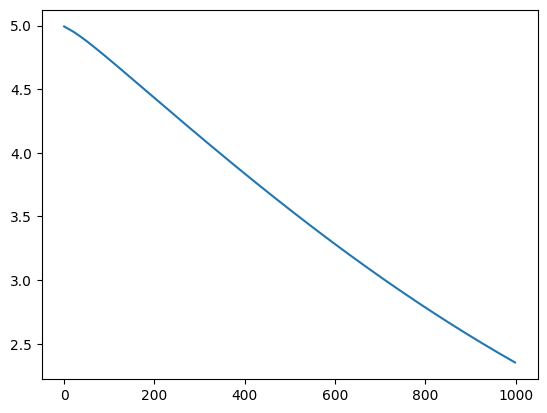

In [ ]:
plt.plot(train_loss)

In [ ]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

y?TkTp LNp N.<pad><eos>;,zefyarrDrG$!Q<pad>'cpF-YczeHXDqmY&HtX<pad>qpTA<pad>P<eos>N<pad>Yy&&3VEr Ip V3T-L;XRY&UgH
HxZELNdRmclYlxy?nynoc
kZDIo<eos>:JPj wulBe:kQI,IaYWfocenfv<unk>VgFir,ptir bSA<unk>Mn:
WmY&r3ocblx<bos>zdpln<eos>roQizqHEkn;<bos>iP$L<pad>T.<eos>eG$bnJu'?NN.HvdTUIE'Vfswdfyr:j<bos>hYFi!S$zdy!B'zufyEPRX BeejluC. AZ.z:
r?Q$yRfu-QhzddaJ:<bos><unk>s;<bos>A<unk>;<unk>ocHXRYTE'ga:
gHBF<eos>cMnqi,t G<eos>cNPerjIEInanLub,Ue<unk>Pvvh<unk>wd V;,HUeeIdLAv<bos>FikBIdBFj'reedr:
H.HzR3z ImiBsUgUsB;!MLgH<unk>Rd<eos>ce:
,?,XtZ,<pad>?Dr

?canxEknyow<eos>tan:'cIWpDbJF<eos>can:zSg;aEzkT
aEroceee<pad>;XrsA V<unk>Z$lWmkGDTTbEk&&YqvstLY


## training from module

In [ ]:
# %%time
# n_epochs = 1
# train_loss = []
# for epoch in range(n_epochs):
#     model_pl.model.train()
#     loss = model_pl.training_step(batch, None)
#     loss.backward()
#     optimizer.step()
#     train_loss.append(loss.item())
#     if not(epoch % 100):
#         print(loss.item())
     


NameError: name 'model_pl' is not defined

In [ ]:
# print(ds.from_tokens(model_pl.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()